# Cognitive Extent: Extension (II) -- NLP w/ Spacy


## Housekeeping

In [276]:
import pandas as pd
import numpy as np
from functools import partial
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 1000

import string
import re

import spacy as s
import en_core_web_sm as en
import en_core_web_lg as en2
import en_vectors_web_lg as env

#from pattern.en import pluralize, singularize
from itertools import compress
 
import time
import swifter
#from pandarallel import pandarallel
from matplotlib import pyplot as plt
import seaborn as sns

In [281]:
sns.set()

In [2]:
from multiprocessing import Pool, cpu_count

In [3]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [160]:
nlp = en.load(disable=['ner','entity_ruler'])

In [4]:
wn_lemma = WordNetLemmatizer()

In [5]:
get_lemma = wn_lemma.lemmatize #speeds up the dot accessor lookup

In [10]:
lemmas_cache = {}
lemmacache_get = lemmas_cache.get
def lemma_cache(word):
    if word=='|':
        return word
    elif '|' in word:
        return "|".join([lemma_cache(z) for z in word.split("|")])
    else:
        a = lemmacache_get(word)
        if a:
            return a
        else:
            lemma = get_lemma(word)
            lemmas_cache[word] = lemma
            return lemma

In [11]:
stopwords_cache = {}
stopwordscache_get = stopwords_cache.get
STOPWORDS = set(stopwords.words('english'))
def stopword_cache(word):
    if word=='|':
        return word
    elif '|' in word:
        return '|'.join([stopword_cache(z) for z in word.split("|")])
    else:
        a = stopwordscache_get(word)                              
        if a:
            return a
        else:
            if word in STOPWORDS:
                result = "|"
            else:
                result = word
            stopwords_cache[word] = result
            return result

In [12]:
#warm up the stopwords cache:
zz = [stopword_cache(cc) for cc in STOPWORDS]

In [13]:
def applyParallel(dfGrouped, func):
    "For applying after a groupby"
    with Pool(cpu_count()) as p:
        ret_list = p.map(func, [group for name, group in dfGrouped])
    return pandas.concat(ret_list)

In [14]:
#from pywsd.utils import lemmatize_sentence

In [15]:
#nlp = en.load()
#nlp = en.load(disable=['ner','entity_ruler'])

# Data Reading

In [ ]:
df = pd.read_csv("./1data_processNEW.csv",engine='c')

In [18]:
df.head()

,pmid,year,title,number_authors
0,12255545,1946,The nutrition of expectant and nursing mothers in relation to maternal and infant mortality and morbidity.,1
1,12278355,1946,Ritual mutilation among primitive peoples.,1
2,12305597,1946,Vitamin-C test for ovulation.,1
3,12332284,1946,The clinical use of oral basal temperatures.,1
4,16016713,1946,The Army Medical Library: In Retrospect and Future.,1


## Preprocessing

In [16]:
"""Before phrases can be extracted from them, the titles were processed in the following way: Periods, colons, semicolons, dashes, and commas were replaced with a code specifying phrase separation. All punctuation symbols were removed, except for ampersands, which were replaced with “and.” Leading and trailing spaces were removed, and multiple spaces were replaced with a single space. Cases were ignored. Numbers and single letters were removed. Singular and plural forms of nouns were collated.""".split('.')

['Before phrases can be extracted from them, the titles were processed in the following way: Periods, colons, semicolons, dashes, and commas were replaced with a code specifying phrase separation',
 ' All punctuation symbols were removed, except for ampersands, which were replaced with “and',
 '” Leading and trailing spaces were removed, and multiple spaces were replaced with a single space',
 ' Cases were ignored',
 ' Numbers and single letters were removed',
 ' Singular and plural forms of nouns were collated',
 '']

In [25]:
df['workingtitle'] = df['title'].str.lower()

In [26]:
# strip leading or trailing brackets. trailing brackets occur when data is "Not Available"
df['workingtitle'] = df['workingtitle'].str.strip('[].')

In [27]:
df = df.replace('Not Available',np.nan)

In [42]:
df = df.replace('not available',np.nan)

In [43]:
df = df[pd.notnull(df['workingtitle'])]

In [44]:
len(df)

15748731

In [37]:
#number of missing titles:
14243892-14243608

284

In [38]:
df = df.drop_duplicates()

In [45]:
groupedbyyear = df[['workingtitle','year']].groupby('year')
sample = groupedbyyear.apply(lambda x: x.sample(10000)['workingtitle'])

In [209]:
sss = sample.reset_index()

# First New Test: Noun Chunks via Spacey

### Explanation

In [313]:
from spacy import displacy

In [296]:
# Phrase seperation in paper titles can be considered an issue of identifying unique "noun phrases"
# Spacy recognizes "noun chunks" via looking at the Part of Speech Tagging as well as the Dependency Parse
# Let's see what these things mean:

In [298]:
#given a title...
test1 = "DETECTION OF LARGE WOODY DEBRIS ACCUMULATIONS IN OLD-GROWTH FORESTS USING SONIC WAVE COLLECTION.".title()

In [297]:
test1

'Detection Of Large Woody Debris Accumulations In Old-Growth Forests Using Sonic Wave Collection'

In [299]:
doc = nlp(test1)

In [302]:
parsed = [[x.text,x.pos_,x.tag_,x.dep_] for x in doc]

In [314]:
testdf = pd.DataFrame(parsed)
testdf.columns = ['Word:','CoarseGrained Part of Speech','FineGrained Part of Speech:','Dependency:']

In [315]:
#... here are the parts of speech and the dependency tags
testdf.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Word:,Detection,Of,Large,Woody,Debris,Accumulations,In,Old,-,Growth,Forests,Using,Sonic,Wave,Collection,.
CoarseGrained Part of Speech,NOUN,ADP,ADJ,PROPN,PROPN,PROPN,ADP,PROPN,PUNCT,PROPN,NOUN,VERB,PROPN,PROPN,PROPN,PUNCT
FineGrained Part of Speech:,NN,IN,JJ,NNP,NNP,NNPS,IN,NNP,HYPH,NNP,NNS,VBG,NNP,NNP,NNP,.
Dependency:,ROOT,prep,amod,compound,compound,pobj,prep,compound,punct,compound,pobj,acl,compound,compound,dobj,punct


In [ ]:
# but this isn't the whole story...

In [316]:
displacy.serve(doc, style='dep')

/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  "__main__", mod_spec)



Using the 'dep' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


In [308]:
#as for the spacy recognized noun chunks:
list(doc.noun_chunks)

[Detection,
 Large Woody Debris Accumulations,
 Old-Growth Forests,
 Sonic Wave Collection]

In [ ]:
#HOw well does this work on real paper titles?

In [311]:
yr1950 = sss[sss['year']==1950]

In [319]:
testb = yr1950.head(30)

In [323]:
for doc in nlp.pipe(testb['workingtitle'].values):
    print(doc)
    print(list(doc.noun_chunks))
    print("\n")

the treatment of leprosy with chloramphenicol; an experimental trial with negative results
[the treatment, leprosy, chloramphenicol, an experimental trial, negative results]


excretion of 11-oxycorticosteroids in paraplegic and rheumatoid arthritic patients
[excretion, arthritic patients]


amebiasis in infants and young children
[amebiasis, infants, young children]


the black crusade of health
[the black crusade, health]


acoustic orientation in biology
[acoustic orientation, biology]


a new anti-epileptic: dimethyl-dithio-hydantoin
[a new anti-epileptic: dimethyl-dithio-hydantoin]


stratigraphic examination of lungs; new aspects in the method
[stratigraphic examination, lungs, new aspects, the method]


electrology and podology
[electrology, podology]


two cases of perforated ulcer in adolescence; contribution and criticism
[two cases, perforated ulcer, adolescence, contribution, criticism]


reduction of maternal mortality due to hemorrhage
[reduction, maternal mortality, hemo

In [210]:
sss = sss[['year','workingtitle']]

In [263]:
def get_cog_ext(sample):
    ncs=[]
    #just as fast as a list comprehension
    for doc in nlp.pipe(sample,batch_size=1000,n_threads=-1,disable=['ner','entity_ruler',
                                                                     'textcat','merge_noun_chunks',
                                                                    'merge_entities','merge_subtokens']):
        ncs.append(list(doc.noun_chunks))
    return len(list(set([item for sublist in ncs for item in sublist])))

In [292]:
aaa = []
for doc in nlp.pipe(yr1948.head(100)['workingtitle'].values):
    aaa.append(list(doc.noun_chunks))

In [293]:
aaa

[[fauces, absence, tonsils],
 [carcinoma, the trachea],
 [cardiovascular syphilis],
 [low backache problem],
 [new concept, the pathogenesis, urinary lithiasis],
 [hodgkin's disease, pregnancy],
 [attempts, purnus virus i, cotton rats, monkeys],
 [a study,
  the effects,
  the intravenous injection,
  hypertonic solutions,
  the heart rates,
  cats,
  dogs],
 [improvement, the control, sheep, ricinus l],
 [analytical treatment, multicomponent systems],
 [the ketogenic action, niacin, the alcohol, niacin],
 [complete occlusal reconstruction, mouth rehabilitation],
 [cystectomy, cancer, the bladder, a woman, one kidney],
 [twin studies, aging, longevity],
 [financial aid, medical education],
 [chronic bilateral spontaneous pneumothorax, difficulties, treatment],
 [transient cerebral paralysis,
  hypertension,
  cerebral embolism,
  special reference,
  the pathogenesis],
 [static refraction, the blood sugar],
 [the diet],
 [the relationship, the private practitioner, the health program],

In [278]:
OUTPUT = sss.groupby('year')['workingtitle'].apply(lambda x: get_cog_ext(x.values))
#careful, this line takes about 15 minutes to run

In [286]:
plt.rcParams['figure.figsize'] = [10,7]

Text(0.5, 1.0, 'Cognitive Extent: Unique Noun Phrases Per Year')

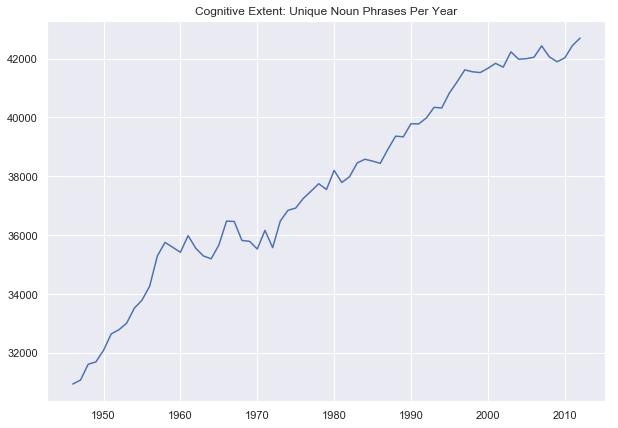

In [287]:
plt.plot(OUTPUT)
plt.title("Cognitive Extent: Unique Noun Phrases Per Year")

In [ ]:
## I also looked into using spacey's built in semantic similarty, but because it's not using biomed vectors, the 
#results were unusable.